In [1]:
import numpy as np
import pandas 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split,learning_curve
from sklearn.metrics import f1_score,precision_recall_curve,plot_confusion_matrix,precision_recall_fscore_support,accuracy_score
from matplotlib import pyplot as plt
import tqdm 

### Some preprocessing to remove rows with NANs and to turn strings into numerical values

In [2]:
DS1 = pandas.read_csv('liver_patient.csv', delimiter=',')
DS2 = pandas.read_csv('fall_detection.csv', delimiter=',')

In [4]:
DS1.loc[DS1['Gender']=='Male','Gender']=1
DS1.loc[DS1['Gender']=='Female','Gender']=0

In [5]:
DS1 = DS1.dropna()

### Class ratios for datasets:

In [7]:
DS1_arr = DS1.values
DS2_arr = DS2.values

X1,y1 = DS1_arr[:,:-1],DS1_arr[:,-1]
y1 -= 1
y1=y1.astype('int')

X2,y2 = DS2_arr[:,1:],DS2_arr[:,0]
y2=y2.astype('int')

In [8]:
counts, unique = np.unique(y1, return_counts=1)
print('labals ratios for Dataset 1', unique/np.sum(unique))

labals ratios for Dataset 1 [0.71502591 0.28497409]


In [9]:
counts, unique = np.unique(y2, return_counts=1)
print('labals ratios for Dataset 1', unique/np.sum(unique))

labals ratios for Dataset 1 [0.28128434 0.03064339 0.1527286  0.21902088 0.21328287 0.10303992]


In [10]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.1)

## KNN

Let's start by finding a good number of neighbors (we'll evaluate accuracy and F1 score)

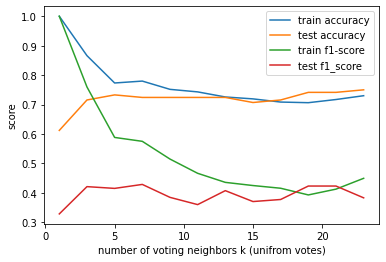

In [436]:
train_acc = []
train_f1 = []
test_acc = []
test_f1 = []
k_range = range(1,25,2)
for k in k_range:
    KNN1 = KNeighborsClassifier(k)
    KNN1.fit(X1_train,y1_train)
    y1_pred = KNN1.predict(X1_test)
    train_pred =  KNN1.predict(X1_train)
    train_f1.append(f1_score(train_pred,y1_train))
    train_acc.append(accuracy_score(train_pred,y1_train))
    test_f1.append(f1_score(y1_pred,y1_test))
    test_acc.append(accuracy_score(y1_pred,y1_test))
    
C1 = plt.plot(k_range,train_acc,label='train accuracy')
C2 = plt.plot(k_range,test_acc,label='test accuracy')
C3 = plt.plot(k_range,train_f1,label='train f1-score')
C4 = plt.plot(k_range,test_f1,label='test f1_score')
plt.ylabel('score')
plt.xlabel('number of voting neighbors k (unifrom votes)')
plt.legend()
plt.show()

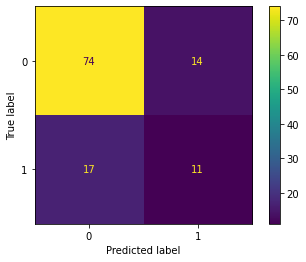

In [435]:
KNN1 = KNeighborsClassifier(5)
KNN1.fit(X1_train,y1_train)
plot_confusion_matrix(KNN1,X1_test,y1_test.reshape(-1,1))

We'll try again using votes weighted by proximity (closest point have strongest votes)

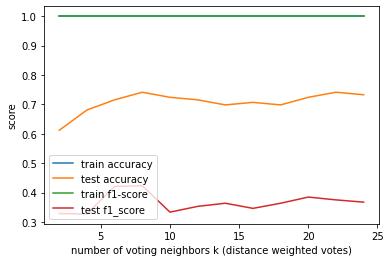

In [400]:
train_acc = []
train_f1 = []
test_acc = []
test_f1 = []
k_range = range(2,25,2)
for k in k_range:
    KNN1 = KNeighborsClassifier(k, weights='distance')
    KNN1.fit(X1_train,y1_train)
    y1_pred = KNN1.predict(X1_test)
    train_pred =  KNN1.predict(X1_train)
    train_f1.append(f1_score(train_pred,y1_train))
    train_acc.append(accuracy_score(train_pred,y1_train))
    test_f1.append(f1_score(y1_pred,y1_test))
    test_acc.append(accuracy_score(y1_pred,y1_test))
    
C1 = plt.plot(k_range,train_acc,label='train accuracy')
C2 = plt.plot(k_range,test_acc,label='test accuracy')
C3 = plt.plot(k_range,train_f1,label='train f1-score')
C4 = plt.plot(k_range,test_f1,label='test f1_score')
plt.ylabel('score')
plt.xlabel('number of voting neighbors k (distance weighted votes)')
plt.legend()
plt.show()

Using these two different kernels, 5 seems like an appropriate k with uniform votes to avoid over and underfitting.
Let's take a look at our learning curve for this classifier.

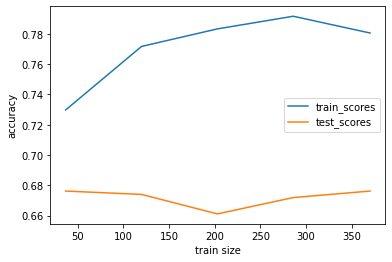

In [434]:
train_sizes, train_scores, test_scores = learning_curve(KNeighborsClassifier(5), X1_train, y1_train, cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes,train_scores_mean,label='train_scores')
plt.plot(train_sizes,test_scores_mean,label='test_scores')
plt.ylabel('accuracy')
plt.xlabel('train size')
plt.legend()

It seems that we could use more data, size at the end of our dataset the test score seems to be yet increasing.
Let's reenact the same experimentation with our second dataset which is multiclass and has a considerably higher number of datapoints.

In [429]:
def gauss_kernel(dist):
    size =8000
    weights = np.exp(-(dist**2)/size)
    return weights

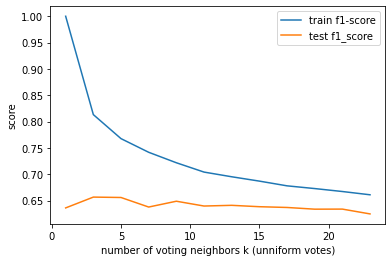

In [423]:
train_f1 = []
test_f1 = []
k_range = range(1,25,2)
for k in k_range:
    KNN1 = KNeighborsClassifier(k)
    KNN1.fit(X2_train,y2_train)
    y2_pred = KNN1.predict(X2_test)
    train_pred =  KNN1.predict(X2_train)
    train_f1.append(f1_score(train_pred,y2_train,average='weighted'))
    test_f1.append(f1_score(y2_pred,y2_test,average='weighted'))

    
C3 = plt.plot(k_range,train_f1,label='train f1-score')
C4 = plt.plot(k_range,test_f1,label='test f1_score')
plt.ylabel('score')
plt.xlabel('number of voting neighbors k (unniform votes)')
plt.legend()
plt.show()

100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


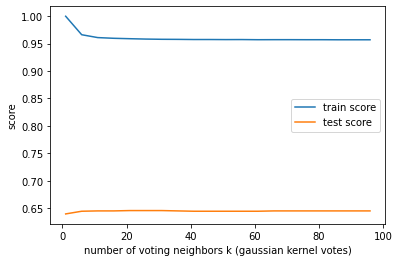

In [430]:
train_f1 = []
test_f1 = []
k_range = range(1,100,5)
for k in tqdm.tqdm(k_range):
    KNN1 = KNeighborsClassifier(k,weights=gauss_kernel)
    KNN1.fit(X2_train,y2_train)
    y2_pred = KNN1.predict(X2_test)
    train_pred =  KNN1.predict(X2_train)
    train_f1.append(accuracy_score(train_pred,y2_train))
    test_f1.append(accuracy_score(y2_pred,y2_test))

    
C3 = plt.plot(k_range,train_f1,label='train score')
C4 = plt.plot(k_range,test_f1,label='test score')
plt.ylabel('score')
plt.xlabel('number of voting neighbors k (gaussian kernel votes)')
plt.legend()
plt.show()

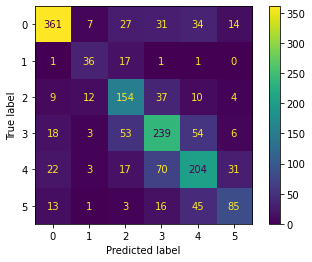

In [416]:
KNN1 = KNeighborsClassifier(5)
KNN1.fit(X2_train,y2_train)
plot_confusion_matrix(KNN1,X2_test,y2_test.reshape(-1,1))

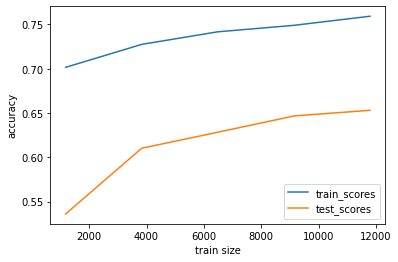

In [393]:
train_sizes, train_scores, test_scores = learning_curve(KNeighborsClassifier(5), X2_train, y2_train, cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes,train_scores_mean,label='train_scores')
plt.plot(train_sizes,test_scores_mean,label='test_scores')
plt.ylabel('accuracy')
plt.xlabel('train size')
plt.legend()

# SVM

  0%|          | 0/25 [00:00<?, ?it/s]/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=0.01 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=0.42625 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=0.8425 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=1.25875 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validati

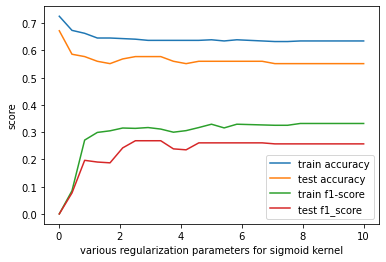

In [12]:
train_acc = []
train_f1 = []
test_acc = []
test_f1 = []
c_val = np.linspace(0.01,10,25)
for c in tqdm.tqdm(c_val):
    clf = SVC(c,kernel='sigmoid')
    clf.fit(X1_train,y1_train)
    y1_pred = clf.predict(X1_test)
    train_pred =  clf.predict(X1_train)
    train_f1.append(f1_score(train_pred,y1_train))
    train_acc.append(accuracy_score(train_pred,y1_train))
    test_f1.append(f1_score(y1_pred,y1_test))
    test_acc.append(accuracy_score(y1_pred,y1_test))
    
C1 = plt.plot(c_val,train_acc,label='train accuracy')
C2 = plt.plot(c_val,test_acc,label='test accuracy')
C3 = plt.plot(c_val,train_f1,label='train f1-score')
C4 = plt.plot(c_val,test_f1,label='test f1_score')
plt.ylabel('score')
plt.xlabel('various regularization parameters for sigmoid kernel')
plt.legend()
plt.show()

In [43]:
train_acc = []
train_f1 = []
test_acc = []
test_f1 = []
d_val = list(range(4))
for d in tqdm.tqdm(d_val):
    clf = SVC(7,kernel='poly',degree=d, gamma=0.006)
    clf.fit(X1_train,y1_train)
    y1_pred = clf.predict(X1_test)
    train_pred =  clf.predict(X1_train)
    train_f1.append(f1_score(train_pred,y1_train))
    train_acc.append(accuracy_score(train_pred,y1_train))
    test_f1.append(f1_score(y1_pred,y1_test))
    test_acc.append(accuracy_score(y1_pred,y1_test))
    
C1 = plt.plot(d_val,train_acc,label='train accuracy')
C2 = plt.plot(d_val,test_acc,label='test accuracy')
C3 = plt.plot(d_val,train_f1,label='train f1-score')
C4 = plt.plot(d_val,test_f1,label='test f1_score')
plt.ylabel('score')
plt.xlabel('poly degree value')
plt.legend()
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=7 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=7 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
 50%|█████     | 2/4 [00:06<00:06,  3.12s/it]/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=7 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
 75%|███████▌  | 3/4 [04:21<01:18, 78.76s/it]/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=7 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
 

KeyboardInterrupt: 

  0%|          | 0/10 [00:00<?, ?it/s]/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: Future

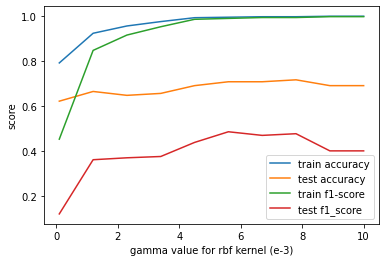

In [29]:
train_acc = []
train_f1 = []
test_acc = []
test_f1 = []
g_val = np.linspace(0.1,10,10)
for g in tqdm.tqdm(g_val):
    clf = SVC(10,kernel='rbf',gamma=g*10**(-3))
    clf.fit(X1_train,y1_train)
    y1_pred = clf.predict(X1_test)
    train_pred =  clf.predict(X1_train)
    train_f1.append(f1_score(train_pred,y1_train))
    train_acc.append(accuracy_score(train_pred,y1_train))
    test_f1.append(f1_score(y1_pred,y1_test))
    test_acc.append(accuracy_score(y1_pred,y1_test))
    
C1 = plt.plot(g_val,train_acc,label='train accuracy')
C2 = plt.plot(g_val,test_acc,label='test accuracy')
C3 = plt.plot(g_val,train_f1,label='train f1-score')
C4 = plt.plot(g_val,test_f1,label='test f1_score')
plt.ylabel('score')
plt.xlabel('gamma value for rbf kernel (e-3)')
plt.legend()
plt.show()

/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


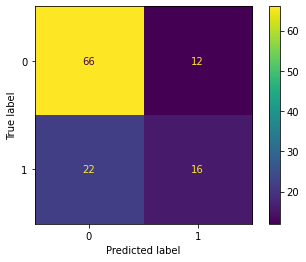

In [38]:
clf = SVC(10,gamma=0.006)
clf.fit(X1_train,y1_train)
plot_confusion_matrix(clf,X1_test,y1_test.reshape(-1,1))

/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


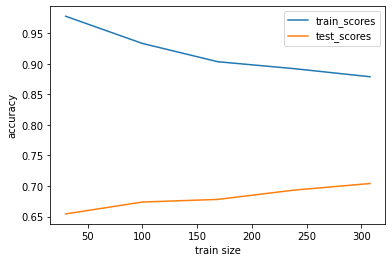

In [40]:
clf = SVC(10,gamma=0.0006)
train_sizes, train_scores, test_scores = learning_curve(clf, X1_train, y1_train, cv=3)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes,train_scores_mean,label='train_scores')
plt.plot(train_sizes,test_scores_mean,label='test_scores')
plt.ylabel('accuracy')
plt.xlabel('train size')
plt.legend()

for the second dataset

  0%|          | 0/5 [00:00<?, ?it/s]/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=0.01 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
 20%|██        | 1/5 [00:16<01:06, 16.64s/it]/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=2.5075 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
 40%|████      | 2/5 [00:29<00:46, 15.39s/it]/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=5.005 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
 60%|██████    | 3/5 [00:41<00:29, 14.54s/it]/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=7.5024999999999995 as keyword args. From version 0.25 passin

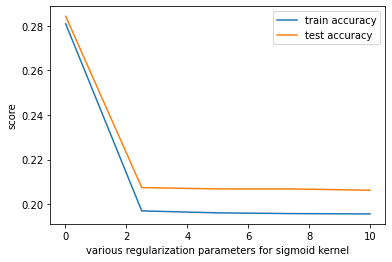

In [32]:
train_acc = []
test_acc = []

c_val = np.linspace(0.01,10,5)
for c in tqdm.tqdm(c_val):
    clf = SVC(c,kernel='sigmoid')
    clf.fit(X2_train,y2_train)
    y2_pred = clf.predict(X2_test)
    train_pred =  clf.predict(X2_train)
    train_acc.append(accuracy_score(train_pred,y2_train))
    test_acc.append(accuracy_score(y2_pred,y2_test))
    
C1 = plt.plot(c_val,train_acc,label='train accuracy')
C2 = plt.plot(c_val,test_acc,label='test accuracy')

plt.ylabel('score')
plt.xlabel('various regularization parameters for sigmoid kernel')
plt.legend()
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
 20%|██        | 1/5 [00:17<01:09, 17.49s/it]/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
 40%|████      | 2/5 [00:34<00:52, 17.37s/it]/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
 60%|██████    | 3/5 [00:51<00:34, 17.28s/it]/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=1 as keyword args. From version 0.25 passing these as positional argumen

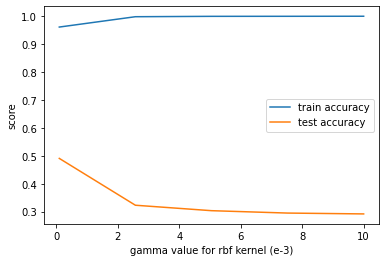

In [34]:
train_acc = []
test_acc = []

g_val = np.linspace(0.1,10,5)
for g in tqdm.tqdm(g_val):
    clf = SVC(1,kernel='rbf',gamma=g*10**(-3))
    clf.fit(X2_train,y2_train)
    y2_pred = clf.predict(X2_test)
    train_pred =  clf.predict(X2_train)

    train_acc.append(accuracy_score(train_pred,y2_train))
    test_acc.append(accuracy_score(y2_pred,y2_test))
    
C1 = plt.plot(g_val,train_acc,label='train accuracy')
C2 = plt.plot(g_val,test_acc,label='test accuracy')

plt.ylabel('score')
plt.xlabel('gamma value for rbf kernel (e-3)')
plt.legend()
plt.show()

/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


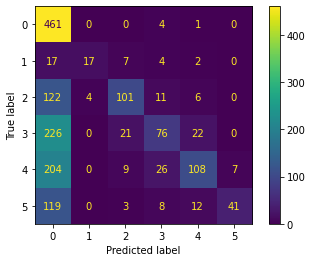

In [36]:
clf = SVC(1,gamma=0.0001)
clf.fit(X2_train,y2_train)
plot_confusion_matrix(clf,X2_test,y2_test.reshape(-1,1))

/home/aymane/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


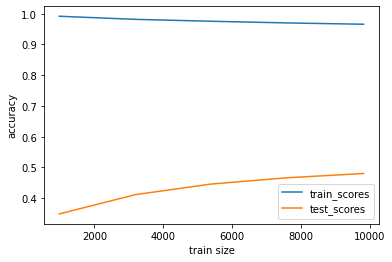

In [37]:
clf = SVC(1,gamma=0.0001)
train_sizes, train_scores, test_scores = learning_curve(clf, X2_train, y2_train, cv=3)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes,train_scores_mean,label='train_scores')
plt.plot(train_sizes,test_scores_mean,label='test_scores')
plt.ylabel('accuracy')
plt.xlabel('train size')
plt.legend()

## Decision tree

100%|██████████| 50/50 [00:00<00:00, 169.91it/s]


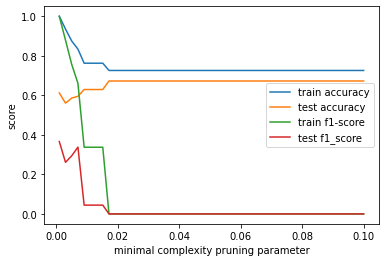

In [203]:
train_acc = []
train_f1 = []
test_acc = []
test_f1 = []
k_range = np.linspace(0.001,0.1,50)
for k in tqdm.tqdm(k_range):
    clf = DecisionTreeClassifier(ccp_alpha=k)
    clf.fit(X1_train,y1_train)
    y1_pred = clf.predict(X1_test)
    train_pred =  clf.predict(X1_train)
    train_f1.append(f1_score(train_pred,y1_train))
    train_acc.append(accuracy_score(train_pred,y1_train))
    test_f1.append(f1_score(y1_pred,y1_test))
    test_acc.append(accuracy_score(y1_pred,y1_test))
    
C1 = plt.plot(k_range,train_acc,label='train accuracy')
C2 = plt.plot(k_range,test_acc,label='test accuracy')
C3 = plt.plot(k_range,train_f1,label='train f1-score')
C4 = plt.plot(k_range,test_f1,label='test f1_score')
plt.ylabel('score')
plt.xlabel('minimal complexity pruning parameter')
plt.legend()
plt.show()

100%|██████████| 25/25 [00:00<00:00, 146.31it/s]


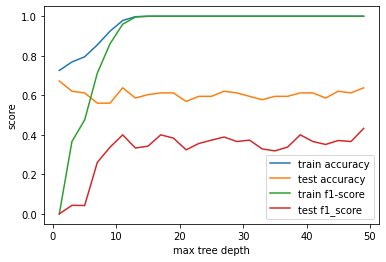

In [84]:
train_acc = []
train_f1 = []
test_acc = []
test_f1 = []
k_range = range(1,50,2)
for k in tqdm.tqdm(k_range):
    clf = DecisionTreeClassifier(max_depth=k)
    clf.fit(X1_train,y1_train)
    y1_pred = clf.predict(X1_test)
    train_pred =  clf.predict(X1_train)
    train_f1.append(f1_score(train_pred,y1_train))
    train_acc.append(accuracy_score(train_pred,y1_train))
    test_f1.append(f1_score(y1_pred,y1_test))
    test_acc.append(accuracy_score(y1_pred,y1_test))
    
C1 = plt.plot(k_range,train_acc,label='train accuracy')
C2 = plt.plot(k_range,test_acc,label='test accuracy')
C3 = plt.plot(k_range,train_f1,label='train f1-score')
C4 = plt.plot(k_range,test_f1,label='test f1_score')
plt.ylabel('score')
plt.xlabel('max tree depth')
plt.legend()
plt.show()

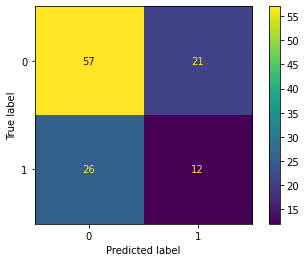

In [78]:
clf = DecisionTreeClassifier(max_depth=15)
clf.fit(X1_train,y1_train)
plot_confusion_matrix(clf,X1_test,y1_test.reshape(-1,1))

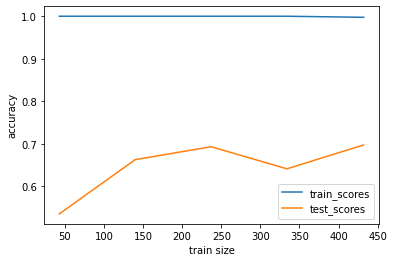

In [81]:
train_sizes, train_scores, test_scores = learning_curve(clf, X1_train, y1_train, cv=15)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes,train_scores_mean,label='train_scores')
plt.plot(train_sizes,test_scores_mean,label='test_scores')
plt.ylabel('accuracy')
plt.xlabel('train size')
plt.legend()

100%|██████████| 25/25 [00:01<00:00, 14.69it/s]


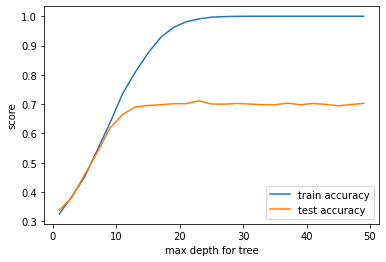

In [85]:
train_acc = []
test_acc = []

k_range = range(1,50,2)
for c in tqdm.tqdm(k_range):
    clf = DecisionTreeClassifier(max_depth=c)
    clf.fit(X2_train,y2_train)
    y2_pred = clf.predict(X2_test)
    train_pred =  clf.predict(X2_train)
    train_acc.append(accuracy_score(train_pred,y2_train))
    test_acc.append(accuracy_score(y2_pred,y2_test))
    
C1 = plt.plot(k_range,train_acc,label='train accuracy')
C2 = plt.plot(k_range,test_acc,label='test accuracy')

plt.ylabel('score')
plt.xlabel('max depth for tree')
plt.legend()
plt.show()

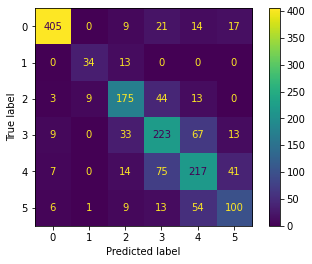

In [86]:
clf = DecisionTreeClassifier(max_depth=20)
clf.fit(X2_train,y2_train)
plot_confusion_matrix(clf,X2_test,y2_test.reshape(-1,1))

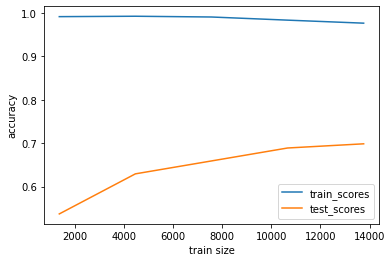

In [87]:
train_sizes, train_scores, test_scores = learning_curve(clf, X2_train, y2_train, cv=15)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes,train_scores_mean,label='train_scores')
plt.plot(train_sizes,test_scores_mean,label='test_scores')
plt.ylabel('accuracy')
plt.xlabel('train size')
plt.legend()

## ADABOOST

100%|██████████| 30/30 [00:00<00:00, 163.59it/s]


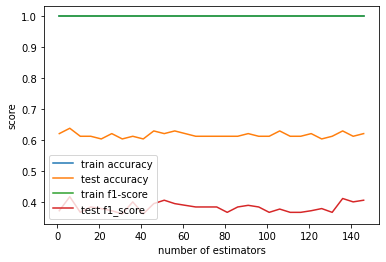

In [218]:
train_acc = []
train_f1 = []
test_acc = []
test_f1 = []
k_range = range(1,150,5)
for k in tqdm.tqdm(k_range):
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15),n_estimators=k)
    clf.fit(X1_train,y1_train)
    y1_pred = clf.predict(X1_test)
    train_pred =  clf.predict(X1_train)
    train_f1.append(f1_score(train_pred,y1_train))
    train_acc.append(accuracy_score(train_pred,y1_train))
    test_f1.append(f1_score(y1_pred,y1_test))
    test_acc.append(accuracy_score(y1_pred,y1_test))
    
C1 = plt.plot(k_range,train_acc,label='train accuracy')
C2 = plt.plot(k_range,test_acc,label='test accuracy')
C3 = plt.plot(k_range,train_f1,label='train f1-score')
C4 = plt.plot(k_range,test_f1,label='test f1_score')
plt.ylabel('score')
plt.xlabel('number of estimators')
plt.legend()
plt.show()

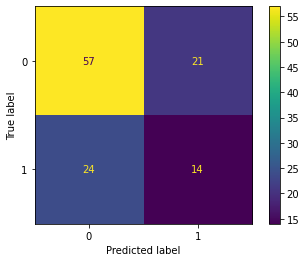

In [217]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15),n_estimators=25)
clf.fit(X1_train,y1_train)
plot_confusion_matrix(clf,X1_test,y1_test.reshape(-1,1))

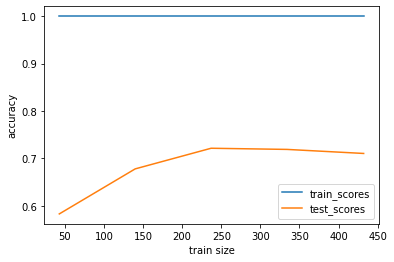

In [107]:
train_sizes, train_scores, test_scores = learning_curve(clf, X1_train, y1_train, cv=15)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes,train_scores_mean,label='train_scores')
plt.plot(train_sizes,test_scores_mean,label='test_scores')
plt.ylabel('accuracy')
plt.xlabel('train size')
plt.legend()

100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


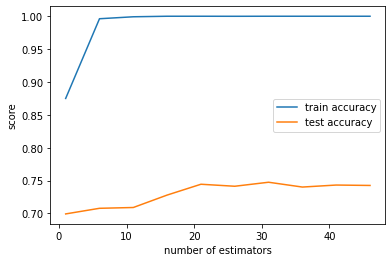

In [109]:
train_acc = []
test_acc = []

k_range = range(1,50,5)
for k in tqdm.tqdm(k_range):
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15),n_estimators=k)
    clf.fit(X2_train,y2_train)
    y2_pred = clf.predict(X2_test)
    train_pred =  clf.predict(X2_train)
    train_acc.append(accuracy_score(train_pred,y2_train))
    test_acc.append(accuracy_score(y2_pred,y2_test))
    
C1 = plt.plot(k_range,train_acc,label='train accuracy')
C2 = plt.plot(k_range,test_acc,label='test accuracy')

plt.ylabel('score')
plt.xlabel('number of estimators')
plt.legend()
plt.show()

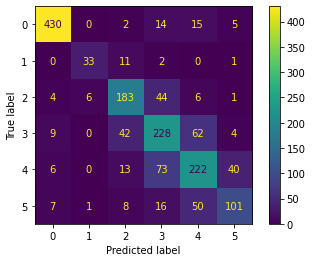

In [110]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15),n_estimators=20)
clf.fit(X2_train,y2_train)
plot_confusion_matrix(clf,X2_test,y2_test.reshape(-1,1))

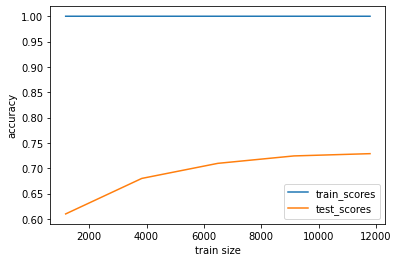

In [111]:
train_sizes, train_scores, test_scores = learning_curve(clf, X2_train, y2_train, cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes,train_scores_mean,label='train_scores')
plt.plot(train_sizes,test_scores_mean,label='test_scores')
plt.ylabel('accuracy')
plt.xlabel('train size')
plt.legend()

# MLP

  0%|          | 0/7 [00:00<?, ?it/s]/home/aymane/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 14%|█▍        | 1/7 [00:00<00:02,  2.34it/s]/home/aymane/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 29%|██▊       | 2/7 [00:00<00:02,  2.17it/s]/home/aymane/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 43%|████▎     | 3/7 [00:01<00:02,  1.96it/s]/home/aymane/.local/lib/python3.6/site-packages/skl

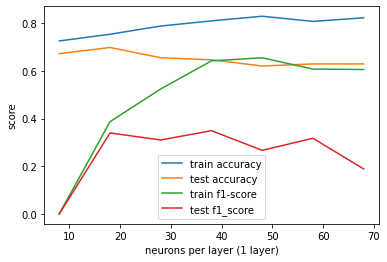

In [204]:
train_acc = []
train_f1 = []
test_acc = []
test_f1 = []
k_range = range(8,70,10)
for k in tqdm.tqdm(k_range):
    clf = MLPClassifier((k,k),'logistic',learning_rate='adaptive')
    clf.fit(np.repeat(X1_train,2,axis=0),np.repeat(y1_train,2))
    y1_pred = clf.predict(X1_test)
    train_pred =  clf.predict(X1_train)
    train_f1.append(f1_score(train_pred,y1_train))
    train_acc.append(accuracy_score(train_pred,y1_train))
    test_f1.append(f1_score(y1_pred,y1_test))
    test_acc.append(accuracy_score(y1_pred,y1_test))
    
C1 = plt.plot(k_range,train_acc,label='train accuracy')
C2 = plt.plot(k_range,test_acc,label='test accuracy')
C3 = plt.plot(k_range,train_f1,label='train f1-score')
C4 = plt.plot(k_range,test_f1,label='test f1_score')
plt.ylabel('score')
plt.xlabel('neurons per layer (1 layer)')
plt.legend()
plt.show()

  0%|          | 0/7 [00:00<?, ?it/s]/home/aymane/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 29%|██▊       | 2/7 [00:00<00:01,  2.94it/s]/home/aymane/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 43%|████▎     | 3/7 [00:01<00:01,  2.41it/s]/home/aymane/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 57%|█████▋    | 4/7 [00:04<00:03,  1.19s/it]/home/aymane/.local/lib/python3.6/site-packages/skl

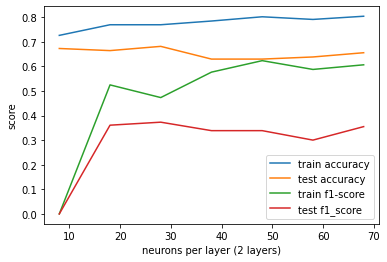

In [205]:
train_acc = []
train_f1 = []
test_acc = []
test_f1 = []
k_range = range(8,70,10)
for k in tqdm.tqdm(k_range):
    clf = MLPClassifier((k,k),'logistic',learning_rate='adaptive')
    clf.fit(np.repeat(X1_train,2,axis=0),np.repeat(y1_train,2))
    y1_pred = clf.predict(X1_test)
    train_pred =  clf.predict(X1_train)
    train_f1.append(f1_score(train_pred,y1_train))
    train_acc.append(accuracy_score(train_pred,y1_train))
    test_f1.append(f1_score(y1_pred,y1_test))
    test_acc.append(accuracy_score(y1_pred,y1_test))
    
C1 = plt.plot(k_range,train_acc,label='train accuracy')
C2 = plt.plot(k_range,test_acc,label='test accuracy')
C3 = plt.plot(k_range,train_f1,label='train f1-score')
C4 = plt.plot(k_range,test_f1,label='test f1_score')
plt.ylabel('score')
plt.xlabel('neurons per layer (2 layers)')
plt.legend()
plt.show()

100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


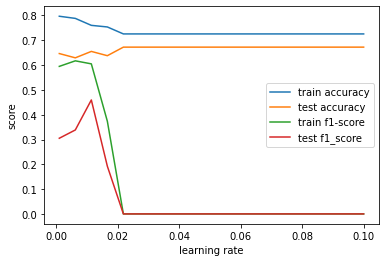

In [168]:
train_acc = []
train_f1 = []
test_acc = []
test_f1 = []
k = 50
lr_range = np.linspace(0.001,0.1,20)
for lr in tqdm.tqdm(lr_range):
    clf = MLPClassifier((k,k,k),'logistic',learning_rate_init=lr)
    clf.fit(np.repeat(X1_train,2,axis=0),np.repeat(y1_train,2))
    y1_pred = clf.predict(X1_test)
    train_pred =  clf.predict(X1_train)
    train_f1.append(f1_score(train_pred,y1_train))
    train_acc.append(accuracy_score(train_pred,y1_train))
    test_f1.append(f1_score(y1_pred,y1_test))
    test_acc.append(accuracy_score(y1_pred,y1_test))
    
C1 = plt.plot(lr_range,train_acc,label='train accuracy')
C2 = plt.plot(lr_range,test_acc,label='test accuracy')
C3 = plt.plot(lr_range,train_f1,label='train f1-score')
C4 = plt.plot(lr_range,test_f1,label='test f1_score')
plt.ylabel('score')
plt.xlabel('learning rate')
plt.legend()
plt.show()

/home/aymane/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


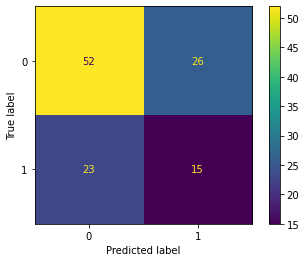

In [172]:
k = 50
clf = MLPClassifier((k,k,k),'logistic',learning_rate_init=0.001)
clf.fit(np.repeat(X1_train,10,axis=0),np.repeat(y1_train,10))
plot_confusion_matrix(clf,X1_test,y1_test.reshape(-1,1))

/home/aymane/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/aymane/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/aymane/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/aymane/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

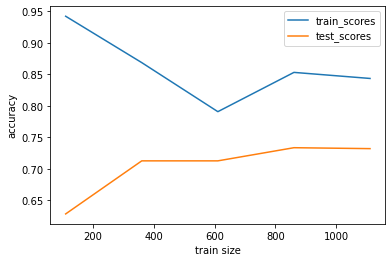

In [173]:
train_sizes, train_scores, test_scores = learning_curve(clf,np.repeat(X1_train,3,axis=0),np.repeat(y1_train,3), cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes,train_scores_mean,label='train_scores')
plt.plot(train_sizes,test_scores_mean,label='test_scores')
plt.ylabel('accuracy')
plt.xlabel('train size')
plt.legend()

100%|██████████| 8/8 [00:18<00:00,  2.25s/it]


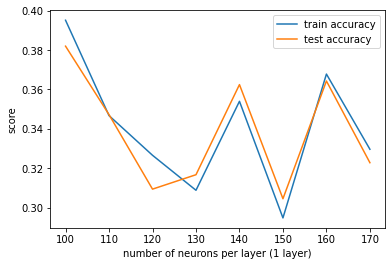

In [190]:
train_acc = []
test_acc = []

k_range = range(100,180,10)
for k in tqdm.tqdm(k_range):
    clf = MLPClassifier((k),'relu')
    clf.fit(X2_train,y2_train)
    y2_pred = clf.predict(X2_test)
    train_pred =  clf.predict(X2_train)
    train_acc.append(accuracy_score(train_pred,y2_train))
    test_acc.append(accuracy_score(y2_pred,y2_test))
    
C1 = plt.plot(k_range,train_acc,label='train accuracy')
C2 = plt.plot(k_range,test_acc,label='test accuracy')

plt.ylabel('score')
plt.xlabel('number of neurons per layer (1 layer)')
plt.legend()
plt.show()

100%|██████████| 10/10 [00:23<00:00,  2.40s/it]


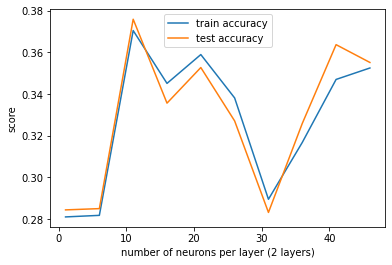

In [189]:
train_acc = []
test_acc = []

k_range = range(1,50,5)
for k in tqdm.tqdm(k_range):
    clf = MLPClassifier((k))
    clf.fit(X2_train,y2_train)
    y2_pred = clf.predict(X2_test)
    train_pred =  clf.predict(X2_train)
    train_acc.append(accuracy_score(train_pred,y2_train))
    test_acc.append(accuracy_score(y2_pred,y2_test))
    
C1 = plt.plot(k_range,train_acc,label='train accuracy')
C2 = plt.plot(k_range,test_acc,label='test accuracy')

plt.ylabel('score')
plt.xlabel('number of neurons per layer (2 layers)')
plt.legend()
plt.show()

100%|██████████| 10/10 [00:43<00:00,  4.36s/it]


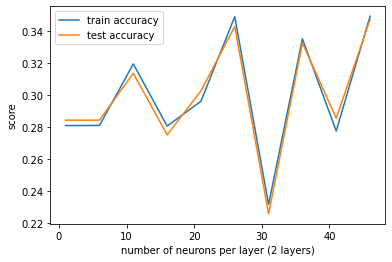

In [181]:
train_acc = []
test_acc = []

k_range = range(1,50,5)
for k in tqdm.tqdm(k_range):
    clf = MLPClassifier((k,k),'relu')
    clf.fit(X2_train,y2_train)
    y2_pred = clf.predict(X2_test)
    train_pred =  clf.predict(X2_train)
    train_acc.append(accuracy_score(train_pred,y2_train))
    test_acc.append(accuracy_score(y2_pred,y2_test))
    
C1 = plt.plot(k_range,train_acc,label='train accuracy')
C2 = plt.plot(k_range,test_acc,label='test accuracy')

plt.ylabel('score')
plt.xlabel('number of neurons per layer (2 layers)')
plt.legend()
plt.show()

100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


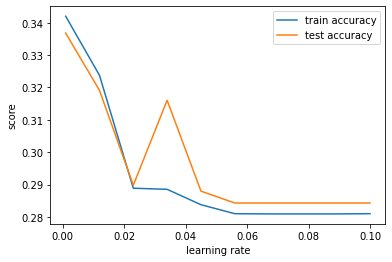

In [206]:
train_acc = []
test_acc = []

k_range = np.linspace(0.001,0.1,10)
for k in tqdm.tqdm(k_range):
    clf = MLPClassifier((32,32),'relu', learning_rate_init=k)
    clf.fit(X2_train,y2_train)
    y2_pred = clf.predict(X2_test)
    train_pred =  clf.predict(X2_train)
    train_acc.append(accuracy_score(train_pred,y2_train))
    test_acc.append(accuracy_score(y2_pred,y2_test))
    
C1 = plt.plot(k_range,train_acc,label='train accuracy')
C2 = plt.plot(k_range,test_acc,label='test accuracy')

plt.ylabel('score')
plt.xlabel('learning rate')
plt.legend()
plt.show()

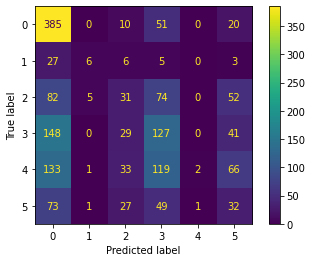

In [201]:
k = 32
clf = MLPClassifier((k,k),learning_rate_init=0.001)
clf.fit(X2_train,y2_train)
plot_confusion_matrix(clf,X2_test,y2_test.reshape(-1,1))

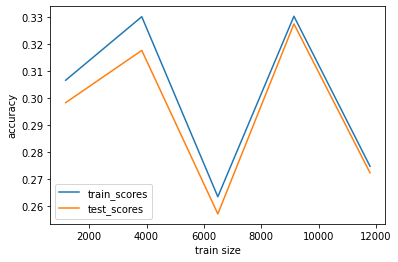

In [188]:
train_sizes, train_scores, test_scores = learning_curve(clf, X2_train, y2_train, cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes,train_scores_mean,label='train_scores')
plt.plot(train_sizes,test_scores_mean,label='test_scores')
plt.ylabel('accuracy')
plt.xlabel('train size')
plt.legend()